# AI Virtual Try On (Real time)



#### real_image (original) -----> pose_map -----> cloth_mask -----> color (dress) -----> TryOn_image (generated)

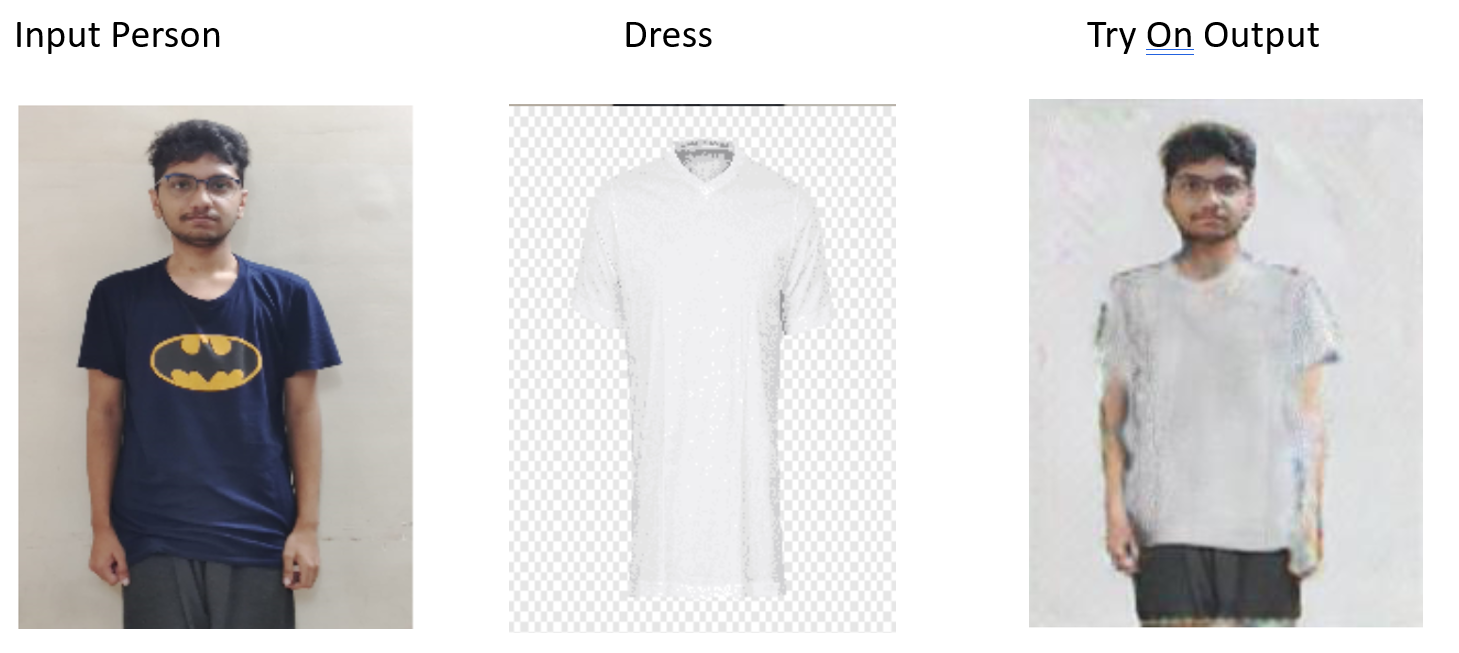

## Dataset: VITON dataset 
    This dataset contains 16,253 image pairs, further splitting into a training set of 14,221 paris and a testing set of 2,032 pairs.
    Further, it's combined with a 70 Gb Dress Dataset

## Copying Dataset

In [1]:
!mkdir Dataset

#### Copying the  VITON dataset (color, edge, mask, colormask)

In [2]:
# copy VITON dataset
!cp /test_color Dataset
!cp /test_edge Dataset
!cp /test_mask Dataset
!cp /test_colormask Dataset

#### copy TestData (image, pose, label)

In [3]:
# copy TestData
!cp -r /Dataset/test_img Dataset
!cp -r /Dataset/test_pose Dataset
!cp -r /Dataset/test_label Dataset
!rm Dataset/test_pose/*
!rm Dataset/test_label/*

# Semantic Segmentation: 
## Using the [PSPNet]-MobileNet-v2


![](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fhszhao.github.io%2Fprojects%2Fpspnet%2Ffigures%2Fpspnet.png&f=1&nofb=1)

In [4]:
cd semantic-segmentation-pytorch

Cloning into 'semantic-segmentation-pytorch'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 530 (delta 185), reused 174 (delta 174), pack-reused 337
Receiving objects: 100% (530/530), 37.47 MiB | 21.50 MiB/s, done.
Resolving deltas: 100% (293/293), done.
/kaggle/working/semantic-segmentation-pytorch


In [5]:
from torchvision import transforms

from segmentation.data_loader.segmentation_dataset import SegmentationDataset
from segmentation.data_loader.transform import Rescale, ToTensor
from segmentation.trainer import Trainer
from segmentation.predict import *
from segmentation.models import all_models
from util.logger import Logger

In [6]:
model_name = "pspnet_mobilenet_v2"
device = 'cuda'
batch_size = 4
n_classes = 34 
check_point_stride = 1 # store checkpoints every 1 epoch   
image_axis_minimum_size = 200

num_epochs = 0    # 1 for 1st training
                  # n for retraining
                  # 0 for detect-only
pretrained = False# True  for num_epochs=1 without logger.load_model below
                  # False for num_epochs=n with    logger.load_model below
                  # False for detect-only  with    logger.load_model below
fixed_feature = False

logger = Logger(model_name=model_name, data_name='example')

In [7]:
### Model
model = all_models.model_from_name[model_name](n_classes, batch_size, 
                                               pretrained=pretrained, 
                                               fixed_feature=fixed_feature)
model.to(device)

PSPnet(
  (features): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU6(inplace=True)
      (5): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)


## Load checkpoint 

In [8]:
# copy checkpoint
!mkdir -p runs/models/pspnet_mobilenet_v2/example
!cp /input/pspnet-viton-checkpoints/epoch_1 runs/models/pspnet_mobilenet_v2/example

# Load checkpoint
logger.load_model(model,'epoch_1')

## Detect label (semantic segmentation)

In [9]:
test_img_file   = '../Dataset/test_img/000000_0.jpg'
test_label_file = '../Dataset/test_label/000000_0.png'

In [10]:
### Writing gray label
predict(model, test_img_file, test_label_file )

tensor([[[[ 5.2723,  6.3288,  7.0349,  ...,  7.5054,  6.7746,  5.9738],
          [ 6.2968,  7.8555,  8.7414,  ...,  9.6500,  8.6736,  7.2959],
          [ 6.8202,  8.4845,  9.4365,  ..., 10.5492,  9.4190,  7.8087],
          ...,
          [ 4.6785,  4.8770,  5.0277,  ...,  2.5857,  2.7445,  3.6376],
          [ 4.4325,  4.5552,  4.7164,  ...,  2.5518,  2.6902,  3.5511],
          [ 4.6346,  4.7003,  4.8010,  ...,  2.9970,  3.1617,  3.8772]],

         [[-0.5992, -0.3138, -0.2301,  ...,  0.3897,  0.3455, -0.1936],
          [-0.4238, -0.6280, -0.5844,  ...,  0.3296,  0.4517,  0.1895],
          [-0.4610, -0.6397, -0.5355,  ...,  0.3618,  0.4405,  0.4066],
          ...,
          [-1.1709, -1.4272, -1.5262,  ..., -0.8571, -0.8166, -1.0958],
          [-1.2855, -1.6013, -1.7118,  ..., -0.9768, -0.9104, -1.1873],
          [-1.4019, -1.5588, -1.6279,  ..., -1.2139, -1.1509, -1.2249]],

         [[-3.3726, -3.3612, -3.3401,  ..., -3.5450, -3.5110, -3.4774],
          [-3.4942, -3.7274, -

## Show image & its label (segmentation)

In [11]:
from IPython.display import Image

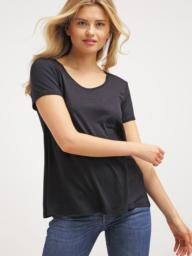

In [12]:
# show test image
Image(test_img_file)

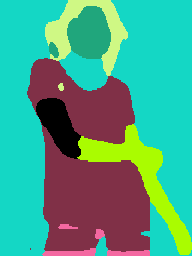

In [13]:
# show test color label
Image(test_label_file)

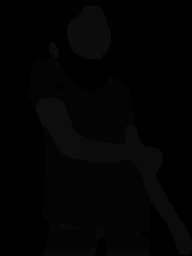

In [14]:
# show test gray label
Image(test_label_file.replace('.png','_gray.png'))

In [15]:
# copy gray label to overwrite color label as test_label .png
!mv ../Dataset/test_label/000000_0_gray.png ../Dataset/test_label/000000_0.png

# Pose Detection: [PoseNet](https://arxiv.org/abs/1505.07427)

![](https://github.com/tensorflow/tfjs-models/raw/master/posenet/demos/camera.gif)

In [17]:
!pip install tfjs-graph-converter

     |████████████████████████████████| 85 kB 2.3 MB/s eta 0:00:011
     |████████████████████████████████| 214 kB 28.0 MB/s eta 0:00:01
     |████████████████████████████████| 210 kB 49.7 MB/s eta 0:00:01
     |████████████████████████████████| 204 kB 59.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 49.9 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 43.4 MB/s eta 0:00:01
     |████████████████████████████████| 154 kB 60.1 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 2.8 MB/s  eta 0:00:01
     |████████████████████████████████| 66 kB 4.4 MB/s  eta 0:00:01
     |████████████████████████████████| 140 kB 60.0 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 4.9 MB/s  eta 0:00:01
     |████████████████████████████████| 596 kB 61.0 MB/s eta 0:00:01
     |████████████████████████████████| 238 kB 54.5 MB/s eta 0:00:01
     |████████████████████████████████| 84 kB 2.9 MB/s  eta 0:00:01
     |████████████████████████████████

# (PoseNet-PyTorch)

In [18]:
%cd posenet-pytorch

Cloning into 'posenet-pytorch'...
remote: Enumerating objects: 115, done.
remote: Total 115 (delta 0), reused 0 (delta 0), pack-reused 115
Receiving objects: 100% (115/115), 34.73 KiB | 404.00 KiB/s, done.
Resolving deltas: 100% (62/62), done.
/kaggle/working/posenet-pytorch


In [8]:
import ipywidgets as widgets
from IPython.display import display


main_display = widgets.Output()

def show_it(inputs):
    with main_display:
        main_display.clear_output()
        display(list(inputs['new'].keys())[-1])

upload = widgets.FileUpload(
    accept='.csv',
    multiple=False
)

upload.observe(show_it, names='value')

In [9]:
upload

FileUpload(value={}, accept='.csv', description='Upload')

In [10]:
main_display

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "'submission (1).csv'"}, 'metadata': {}…

In [11]:
s=(main_display)

In [12]:
s

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "'submission (1).csv'"}, 'metadata': {}…

In [19]:
file = '../Dataset/test_img/000000_0.jpg'

In [20]:
import torch
from posenet.constants import *
from posenet.decode_multi import decode_multiple_poses
from posenet.models.model_factory import load_model
from posenet.utils import *

net = load_model(101)
net = net.cuda()
output_stride = net.output_stride
scale_factor = 1.0

input_image, draw_image, output_scale = posenet.read_imgfile(file, scale_factor=scale_factor, output_stride=output_stride)

Cannot find models file ./_models/mobilenet_v1_101.pth, converting from tfjs...
Weights for checkpoint mobilenet_v1_101 are not downloaded. Downloading to /tmp/_posenet_weights ...


## Detecting Pose keypoints

In [21]:
import torch
with torch.no_grad():
    input_image = torch.Tensor(input_image).cuda()

    heatmaps_result, offsets_result, displacement_fwd_result, displacement_bwd_result = net(input_image)

    pose_scores, keypoint_scores, keypoint_coords = posenet.decode_multiple_poses(
        heatmaps_result.squeeze(0),
        offsets_result.squeeze(0),
        displacement_fwd_result.squeeze(0),
        displacement_bwd_result.squeeze(0),
        output_stride=output_stride,
        max_pose_detections=10,
        min_pose_score=0.25)

### finding the keypoint coordinates in poses

In [22]:
import matplotlib.pyplot as plt
# read image
image = plt.imread(file)

poses = []
# find face keypoints & detect face mask
for pi in range(len(pose_scores)):
    if pose_scores[pi] != 0.:
        print('Pose #%d, score = %f' % (pi, pose_scores[pi]))       
        keypoints = keypoint_coords.astype(np.int32) # convert float to integer
        print(keypoints[pi])
        poses.append(keypoints[pi])
print(len(poses))

Pose #0, score = 0.529883
[[ 32  93]
 [ 22  99]
 [ 22  83]
 [ 33 110]
 [ 30  67]
 [ 84 115]
 [ 70  60]
 [147 139]
 [142  67]
 [199 167]
 [149 131]
 [209 127]
 [203  68]
 [266 133]
 [266  63]
 [258 143]
 [263  64]]
1


### showing PoseNet keypoints

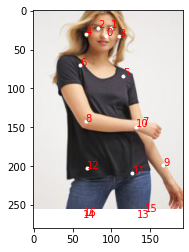

In [23]:
img = plt.imread(file)
i=0
pose = poses[0]
plt.imshow(img)    
for y,x in pose:
    plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
    plt.text(x, y, str(i), color='r', fontsize=10)
    i+=1   
plt.show()

### PoseNet output
![](https://debuggercafe.com/wp-content/uploads/2020/10/keypoint_exmp.jpg)

### OpenPose COCO format
![](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/.github/media/keypoints_pose_18.png?raw=true)

## Converting the Keypoints (from PoseNet to OpenPose)

In [24]:
# map rccpose-to-openpose mapping
indices = [0, (5,6), 6, 8, 10, 5, 7, 9, 12, 14, 16, 11, 13, 15, 2, 1, 4, 3]

In [25]:
# convert rcnnpose to openpose
i=0
openpose = []
for ix in indices:
    if ix==(5,6):
        openpose.append([int((pose[5][1]+pose[6][1])/2), int((pose[5][0]+pose[6][0])/2), 1])   
    else:
        openpose.append([int(pose[ix][1]),int(pose[ix][0]),1])        
    i+=1
    
print(openpose)

[[93, 32, 1], [87, 77, 1], [60, 70, 1], [67, 142, 1], [131, 149, 1], [115, 84, 1], [139, 147, 1], [167, 199, 1], [68, 203, 1], [63, 266, 1], [64, 263, 1], [127, 209, 1], [133, 266, 1], [143, 258, 1], [83, 22, 1], [99, 22, 1], [67, 30, 1], [110, 33, 1]]


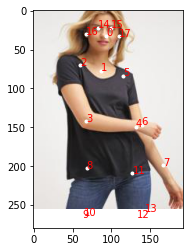

In [26]:
plt.imshow(img)
i=0
for x,y,z in openpose:
    plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
    plt.text(x, y, str(i), color='r', fontsize=10)
    i+=1
plt.show()

### again saving keypoints.json

In [27]:
import json
coords = []
for x,y,z in openpose:
    coords.append(float(x))
    coords.append(float(y))
    coords.append(float(z))

data = {"version": 1.0}
pose_dic = {}
pose_dic['pose_keypoints'] = coords
tmp = []
tmp.append(pose_dic)
data["people"]=tmp
print(data)

pose_name = '../Dataset/test_pose/000000_0_keypoints.json'
with open(pose_name,'w') as f:
     json.dump(data, f)  

{'version': 1.0, 'people': [{'pose_keypoints': [93.0, 32.0, 1.0, 87.0, 77.0, 1.0, 60.0, 70.0, 1.0, 67.0, 142.0, 1.0, 131.0, 149.0, 1.0, 115.0, 84.0, 1.0, 139.0, 147.0, 1.0, 167.0, 199.0, 1.0, 68.0, 203.0, 1.0, 63.0, 266.0, 1.0, 64.0, 263.0, 1.0, 127.0, 209.0, 1.0, 133.0, 266.0, 1.0, 143.0, 258.0, 1.0, 83.0, 22.0, 1.0, 99.0, 22.0, 1.0, 67.0, 30.0, 1.0, 110.0, 33.0, 1.0]}]}


### read .json

In [29]:
# read pose
import numpy as np
import json
#pose_name = 'input/tryon-testdata/Dataset/test_pose/000000_0_keypoints.json'
pose_name = 'Dataset/test_pose/000000_0_keypoints.json'
with open(pose_name, 'r') as f:
     pose_label = json.load(f)
     pose_data = pose_label['people'][0]['pose_keypoints']
     pose_data = np.array(pose_data)
     pose_data = pose_data.reshape((-1,3))
print(pose_data)
print(len(pose_data))

[[ 93.  32.   1.]
 [ 87.  77.   1.]
 [ 60.  70.   1.]
 [ 67. 142.   1.]
 [131. 149.   1.]
 [115.  84.   1.]
 [139. 147.   1.]
 [167. 199.   1.]
 [ 68. 203.   1.]
 [ 63. 266.   1.]
 [ 64. 263.   1.]
 [127. 209.   1.]
 [133. 266.   1.]
 [143. 258.   1.]
 [ 83.  22.   1.]
 [ 99.  22.   1.]
 [ 67.  30.   1.]
 [110.  33.   1.]]
18


### draw keypoints 

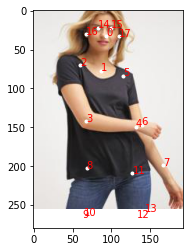

18


In [30]:
# show pose keypoints on the test image
img = plt.imread('Dataset/test_img/000000_0.jpg')
plt.imshow(img)
i=0
for x,y,z in pose_data: 
    plt.plot(x, y, 'w.') # 'w.': color='white', marker='.'
    plt.text(x, y, str(i), color='r', fontsize=10)
    i+=1
plt.show()
print(i)

# Try On:

## (DeepFashion Try On)

In [31]:
%cd DeepFashion_Try_On

Cloning into 'DeepFashion_Try_On'...
remote: Enumerating objects: 261, done.
remote: Total 261 (delta 0), reused 0 (delta 0), pack-reused 261
Receiving objects: 100% (261/261), 13.46 MiB | 20.12 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/kaggle/working/DeepFashion_Try_On


### Download pre-trained model (checkpoint)

In [33]:
# copying the pre-trained model (checkpoint)
!cp -rf input/acgpn-checkpoints/label2city checkpoints

## Test TryOn model 

In [34]:
!python test.py --dataroot ../../Dataset --color_name 000129_1.jpg

?
------------ Options -------------
batchSize: 1
beta1: 0.5
checkpoints_dir: ./checkpoints
color_name: 000129_1.jpg
continue_train: False
data_type: 32
dataroot: ../../Dataset
debug: False
display_freq: 100
display_winsize: 512
fineSize: 512
gpu_ids: [0]
input_nc: 3
isTrain: True
label_nc: 20
lambda_feat: 10.0
loadSize: 512
load_pretrain: ./checkpoints/label2city
lr: 0.0002
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_layers_D: 3
n_local_enhancers: 1
name: label2city
ndf: 64
netG: global
ngf: 64
niter: 100
niter_decay: 100
niter_fix_global: 0
no_flip: False
no_ganFeat_loss: False
no_html: False
no_lsgan: False
no_vgg_loss: False
norm: instance
num_D: 2
output_nc: 3
phase: test
pool_size: 0
print_freq: 100
resize_or_crop: scale_width
save_epoch_freq: 10
save_latest_freq: 1000
serial_batches: False
tf_log: False
use_dropout: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLo

#### output : sample/000000_0.jpg

### Display TryOn result

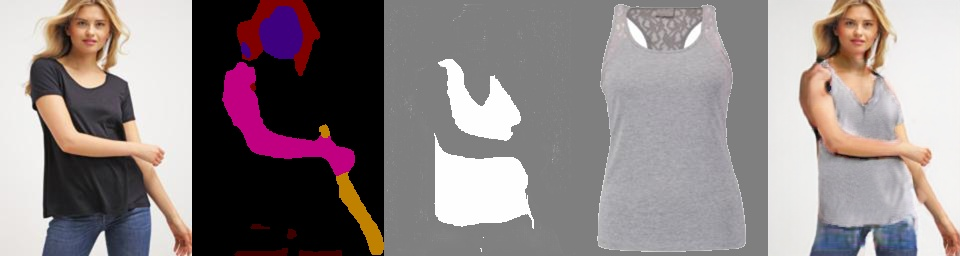

In [36]:
from IPython.display import Image


# Running Real Time, using our Pre-Trained Modules

In [38]:
!pip install -r requirements
!pip install -Uqq fastbook
!pip install --user opencv-python --upgrade
!pwd

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# !pip install -Uqq fastbook
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila
import fastbook
!fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *
#!pip install opencv-contrib-python==4.5.3.56
import cv2
import time
import numpy as np
from random import randint
import argparse
import json 
from PIL import Image
print(cv2. __version__)

4.7.0


'fastbook.setup_book' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
def getKeypoints(probMap, threshold=0.1):

    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []

    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints


# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid

        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ])
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)

                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            ##mod: sharmaa4 print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    return valid_pairs, invalid_pairs


# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])):
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints


In [3]:
import ipywidgets as widgets
from IPython.display import display


main_display = widgets.Output()

def show_it(inputs):
    with main_display:
        main_display.clear_output()
        display(list(inputs['new'].keys())[-1])

upload = widgets.FileUpload(
    accept='.png',
    multiple=False
)

upload.observe(show_it, names='value')

In [4]:
upload

FileUpload(value={}, accept='.png', description='Upload')

In [5]:
main_display

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': "'bilstm-crf_ssd4.png'"}, 'metadata': {…

In [5]:
def on_click_try_on(change):
    
    seconds_start = time.time()
    
    
    
    image_output.clear_output()
    cloth_output.clear_output()
    try_on_output.clear_output()
    runtime_output.clear_output()
    
    image = PILImage.create(image_upload.data[-1])
    cloth = PILImage.create(cloth_upload.data[-1])

    #image_tmp = Image.open("data/test/image/Sample_0.jpg")
    #image_tmp = image_tmp.resize((400,400), resample = Image.NEAREST )
    image_tmp = image
    image_tmp = image_tmp.resize((192,256), resample = Image.NEAREST )
    image_tmp.save("data/test/image/Sample_0.jpg")

    #image_cloth_tmp = Image.open("data/test/cloth-mask/Sample_1.jpg")
    image_cloth_tmp = cloth
    #image_tmp = image_tmp.resize((400,400), resample = Image.NEAREST )
    image_cloth_tmp = image_cloth_tmp.resize((192,256), resample = Image.NEAREST )
    image_cloth_tmp.save("data/test/cloth/Sample_1.jpg")


    
    
    !python exp/inference/inference.py --loadmodel network/inference.pth --img_path data/test/image/Sample_0.jpg  --output_path ./data/test/image-parse-new/ --output_name Sample_0 
    !python body_binary_masking.py
    
    image1 = cv2.imread("data/test/image/Sample_0.jpg")
    
    
    protoFile = "coco/pose_deploy_linevec.prototxt"
    weightsFile = "coco/pose_iter_440000.caffemodel"
    nPoints = 18
    # COCO Output Format
    keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

    POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
                  [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
                  [1,0], [0,14], [14,16], [0,15], [15,17],
                  [2,17], [5,16] ]

    # index of pafs correspoding to the POSE_PAIRS
    # e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
    mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44],
              [19,20], [21,22], [23,24], [25,26], [27,28], [29,30],
              [47,48], [49,50], [53,54], [51,52], [55,56],
              [37,38], [45,46]]

    colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
             [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
             [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]


    frameWidth = image1.shape[1]
    frameHeight = image1.shape[0]

    t = time.time()
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)
    #if args.device == "cpu":
    #net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    #print("Using CPU device")
    # elif args.device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    ##mod: sharmaa4 print("Using GPU device")

    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                              (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()
    print("Time Taken in forward pass = {}".format(time.time() - t))

    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.1

    for part in range(nPoints):
        probMap = output[0,part,:,:]
        probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
        keypoints = getKeypoints(probMap, threshold)
        ##mod: sharmaa4 print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1

        detected_keypoints.append(keypoints_with_id)


    frameClone = image1.copy()
    pose_keypoints = []
    for i in range(nPoints):
        if detected_keypoints[i] ==[]:
            pose_keypoints.append(0)
            pose_keypoints.append(0)
            pose_keypoints.append(0)       

        for j in range(len(detected_keypoints[i])):

            pose_keypoints.append(detected_keypoints[i][j][0])
            pose_keypoints.append(detected_keypoints[i][j][1])
            pose_keypoints.append(detected_keypoints[i][j][2].astype(float))
            cv2.circle(frameClone, detected_keypoints[i][j][0:2], 5, colors[i], -1, cv2.LINE_AA)

    json_data = {"version": 1.0, "people": [
                {"face_keypoints": [],
                "pose_keypoints":pose_keypoints, 
                "hand_right_keypoints": [], 
                "hand_left_keypoints": []
                }]}

    with open('data/test/pose/Sample_0_keypoints.json', 'w') as outfile:
        json.dump(json_data, outfile)

    cv2.imwrite("data/test/pose/Sample_0_pose.jpg" , frameClone)

    

    !python test.py --name GMM --stage GMM --workers 4 --datamode test --data_list test_pairs.txt --checkpoint checkpoints/GMM/gmm_final.pth 
    !python test.py --name TOM --stage TOM --workers 4 --datamode test --data_list test_pairs.txt --checkpoint checkpoints/TOM/tom_final.pth 
    seconds_end = time.time()
    
    try_on = Image.open('data/test/try-on/Sample_0.jpg')
    runtime = seconds_end - seconds_start
    with image_output: display(image_tmp)
    with cloth_output: display(image_cloth_tmp)
    with try_on_output: display(try_on)
    with runtime_output: display(runtime)
    #HBox([image_output,cloth_output,try_on_output])

In [6]:
global image_upload
image_upload = widgets.FileUpload()
#image_upload

global cloth_upload 
cloth_upload = widgets.FileUpload()
#cloth_upload

global image_output
image_output = widgets.Output()

global cloth_output
cloth_output = widgets.Output()

global try_on_output
try_on_output = widgets.Output()

global runtime_output
runtime_output = widgets.Output()


btn_run = widgets.Button(description = 'Generate Try-On')
btn_run.on_click(on_click_try_on)
#out_display_image = widgets.Output()
#out_display_image.clear_output()
#with out_display_image : display(image.to_thumb(128,128))
#out_display_image

#out_display_cloth = widgets.Output()
#out_display_cloth.clear_output()
#with out_display_cloth : display(cloth.to_thumb(128,128))
#out_display_cloth

VBox([widgets.Label('Upload Your Image'),image_upload,widgets.Label('Upload Your Cloth'),cloth_upload,btn_run,
     widgets.Label('Your Try-On Results'),runtime_output,image_output,cloth_output,try_on_output])

C:\Users\SSD\AppData\Local\Temp\ipykernel_15836\3884905105.py:18: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image_tmp = image_tmp.resize((192,256), resample = Image.NEAREST )
C:\Users\SSD\AppData\Local\Temp\ipykernel_15836\3884905105.py:24: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image_cloth_tmp = image_cloth_tmp.resize((192,256), resample = Image.NEAREST )


Constructing DeepLabv3+ model...
Number of classes: 20
Output stride: 16
Number of Input Channels: 3
load model: network/inference.pth
time used for the multi-scale image inference is :2.5617156999999997


C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE4059_Cognitive\cp-vton-plus-sid\body_binary_masking.py:146: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  cloth_mask_cropped_resized = cloth_mask_cropped.resize((192,256),resample = Image.NEAREST)
C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE4059_Cognitive\cp-vton-plus-sid\body_binary_masking.py:153: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  cloth_cropped_resized = cloth_cropped.resize((192,256),resample = Image.NEAREST)
C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE4059_Cognitive\cp-v

Sample_0.jpg
(192, 256)
(192, 256)
Sample_1.jpg
(192, 256)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
8 32 184 225
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
8 32 184 225
0.1210789680480957
Time Taken in forward pass = 2.8999979496002197
Start to test stage: GMM, named: GMM!
initialization method [norma

C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Start to test stage: TOM, named: TOM!
Dataset size: 00001!
step:        1, time: 1.732
Finished test TOM, named: TOM!


C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## For Final Review, using a Loop, to get back the User's response on the given output, and using NLP, getting the emotions/way of response right, and using other resources to make the given changes/find similar things.

In [9]:
global image_upload
image_upload = widgets.FileUpload()
#image_upload

global cloth_upload 
cloth_upload = widgets.FileUpload()
#cloth_upload

global image_output
image_output = widgets.Output()

global cloth_output
cloth_output = widgets.Output()

global try_on_output
try_on_output = widgets.Output()

global runtime_output
runtime_output = widgets.Output()


btn_run = widgets.Button(description = 'Generate Try-On')
btn_run.on_click(on_click_try_on)
#out_display_image = widgets.Output()
#out_display_image.clear_output()
#with out_display_image : display(image.to_thumb(128,128))
#out_display_image

#out_display_cloth = widgets.Output()
#out_display_cloth.clear_output()
#with out_display_cloth : display(cloth.to_thumb(128,128))
#out_display_cloth

VBox([widgets.Label('Upload Your Image'),image_upload,widgets.Label('Upload Your Cloth'),cloth_upload,btn_run,
     widgets.Label('Your Try-On Results'),runtime_output,image_output,cloth_output,try_on_output])

C:\Users\SSD\AppData\Local\Temp\ipykernel_15836\3884905105.py:18: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image_tmp = image_tmp.resize((192,256), resample = Image.NEAREST )
C:\Users\SSD\AppData\Local\Temp\ipykernel_15836\3884905105.py:24: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image_cloth_tmp = image_cloth_tmp.resize((192,256), resample = Image.NEAREST )


Constructing DeepLabv3+ model...
Number of classes: 20
Output stride: 16
Number of Input Channels: 3
load model: network/inference.pth
time used for the multi-scale image inference is :2.9661422999999996


C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE4059_Cognitive\cp-vton-plus-sid\body_binary_masking.py:146: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  cloth_mask_cropped_resized = cloth_mask_cropped.resize((192,256),resample = Image.NEAREST)
C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE4059_Cognitive\cp-vton-plus-sid\body_binary_masking.py:153: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  cloth_cropped_resized = cloth_cropped.resize((192,256),resample = Image.NEAREST)
C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE4059_Cognitive\cp-v

Sample_0.jpg
(192, 256)
(192, 256)
Sample_1.jpg
(192, 256)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
8 32 184 225
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
8 32 184 225
0.09585785865783691
Time Taken in forward pass = 1.9499492645263672
Start to test stage: GMM, named: GMM!
initialization method [norm

C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Start to test stage: TOM, named: TOM!
Dataset size: 00001!
step:        1, time: 1.496
Finished test TOM, named: TOM!


C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Real life image

In [10]:
global image_upload
image_upload = widgets.FileUpload()
#image_upload

global cloth_upload 
cloth_upload = widgets.FileUpload()
#cloth_upload

global image_output
image_output = widgets.Output()

global cloth_output
cloth_output = widgets.Output()

global try_on_output
try_on_output = widgets.Output()

global runtime_output
runtime_output = widgets.Output()


btn_run = widgets.Button(description = 'Generate Try-On')
btn_run.on_click(on_click_try_on)
#out_display_image = widgets.Output()
#out_display_image.clear_output()
#with out_display_image : display(image.to_thumb(128,128))
#out_display_image

#out_display_cloth = widgets.Output()
#out_display_cloth.clear_output()
#with out_display_cloth : display(cloth.to_thumb(128,128))
#out_display_cloth

VBox([widgets.Label('Upload Your Image'),image_upload,widgets.Label('Upload Your Cloth'),cloth_upload,btn_run,
     widgets.Label('Your Try-On Results'),runtime_output,image_output,cloth_output,try_on_output])

C:\Users\SSD\AppData\Local\Temp\ipykernel_15836\3884905105.py:18: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image_tmp = image_tmp.resize((192,256), resample = Image.NEAREST )
C:\Users\SSD\AppData\Local\Temp\ipykernel_15836\3884905105.py:24: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image_cloth_tmp = image_cloth_tmp.resize((192,256), resample = Image.NEAREST )


Constructing DeepLabv3+ model...
Number of classes: 20
Output stride: 16
Number of Input Channels: 3
load model: network/inference.pth
time used for the multi-scale image inference is :2.4177976


C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE4059_Cognitive\cp-vton-plus-sid\body_binary_masking.py:146: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  cloth_mask_cropped_resized = cloth_mask_cropped.resize((192,256),resample = Image.NEAREST)
C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE4059_Cognitive\cp-vton-plus-sid\body_binary_masking.py:153: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  cloth_cropped_resized = cloth_cropped.resize((192,256),resample = Image.NEAREST)
C:\Users\SSD\VITc_SSD1125_Progms\6-SSD_Sem\CSE4059_Cognitive\cp-v

Sample_0.jpg
(192, 256)
(192, 256)
Sample_1.jpg
(192, 256)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]
8 32 184 225
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
8 32 184 225
0.09119081497192383
Time Taken in forward pass = 2.2071497440338135
Start to test stage: GMM, named: GMM!
initialization method [norm

C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Start to test stage: TOM, named: TOM!
Dataset size: 00001!
step:        1, time: 1.460
Finished test TOM, named: TOM!


C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
C:\Users\SSD\anaconda3\envs\X360SpctreGPU\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [11]:
global image_upload
image_upload = widgets.FileUpload()
#image_upload

global cloth_upload 
cloth_upload = widgets.FileUpload()
#cloth_upload

global image_output
image_output = widgets.Output()

global cloth_output
cloth_output = widgets.Output()

global try_on_output
try_on_output = widgets.Output()

global runtime_output
runtime_output = widgets.Output()


btn_run = widgets.Button(description = 'Generate Try-On')
btn_run.on_click(on_click_try_on)
#out_display_image = widgets.Output()
#out_display_image.clear_output()
#with out_display_image : display(image.to_thumb(128,128))
#out_display_image

#out_display_cloth = widgets.Output()
#out_display_cloth.clear_output()
#with out_display_cloth : display(cloth.to_thumb(128,128))
#out_display_cloth

VBox([widgets.Label('Upload Your Image'),image_upload,widgets.Label('Upload Your Cloth'),cloth_upload,btn_run,
     widgets.Label('Your Try-On Results'),runtime_output,image_output,cloth_output,try_on_output])